In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
# Previous line required to plot images in the notebook

/Users/andriimaksai/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
IMAGE_PATH = '/Users/andriimaksai/PhD/Data/MOTChallengeFormat/test/towncentre_00001_00150/img1/%06d.jpg'
GT_PATH = '/Users/andriimaksai/PhD/Data/MOTChallengeFormat/test/towncentre_00001_00150/gt/gt.txt'

Frame 1


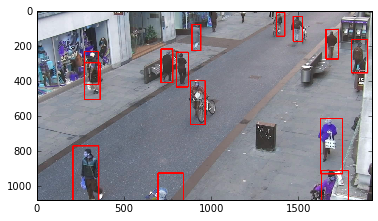

Frame 11


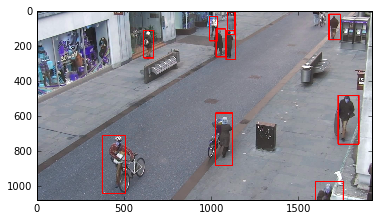

Frame 21


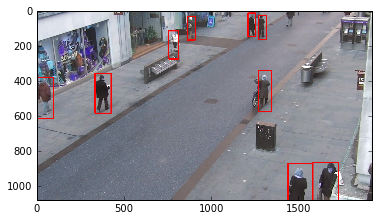

Frame 31


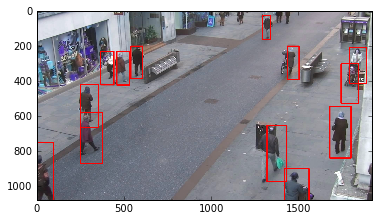

Frame 41


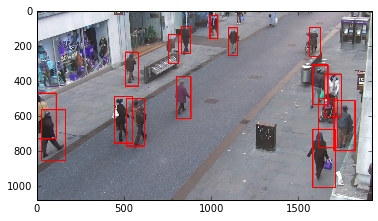

In [3]:
# Checking how our data looks

# Procedure to show the gt bounding boxes for a particular frame
def draw_gt_bounding_boxes(frame_num):
    img = cv2.imread(IMAGE_PATH % frame_num)
    data = np.loadtxt(GT_PATH,delimiter=',')
    data = data[:, [0, 2, 3, 4, 5]]
    data = data[data[:, 0] == frame_num]
    data = np.int32(data)
    # Columns corresponding to t, x, y, w, h
    # Rows corresponding to our frame
    for bbox_idx in range(len(data)):
        cv2.rectangle(img,
                      pt1 = (data[bbox_idx, 1], data[bbox_idx, 2]), 
                      pt2 = (data[bbox_idx, 1] + data[bbox_idx, 3], data[bbox_idx, 2] + data[bbox_idx, 4]), 
                      color = (255, 0, 0), 
                      thickness = 5)
    return img

# Now let's plot some data
for frame_num in range(1, 50, 10):
    print 'Frame %d' % frame_num
    plt.imshow(draw_gt_bounding_boxes(frame_num))
    plt.show()

#You can instead save an image as a file and view this file fullscreen
#cv2.imwrite('tmp.png', img)

In [4]:
# Let's compute the represetation of a particular bounding box
# This is where you should implement computing the color histogram
# Each bounding box will be represented by 3B features, where B
# is the number of bins in the color histogram for R, G, and B colors
# I will instead for simplicity use just one feature - average intensity in the bounding box
def bounding_box_to_feature_vector(bbox_image):
    # We assume bbox_image to be a small patch of the image
    return np.array([np.mean(bbox_image)])

In [5]:
# Let's compute what is the distance between the two bounding boxes
# This is the distance between their representations
# Intuitively, the smaller the distance, the more likely it is that those two are the same person
# This is where you should implement the Bhattacharyya distance between the histograms
# I will instead for simplicity use just the absolute value of difference between the intensities
# Normalized between 0 and 1.
def distance_between_representations(r1, r2):
    return np.abs(r1 - r2) / 255.

In [6]:
# Helper function to read the bounding box contents
def read_bounding_box(x, y, w, h, t):
    img = cv2.imread(IMAGE_PATH % t)
    x1 = max(1, x)
    y1 = max(1, y)
    x2 = min(img.shape[1], x + w)
    y2 = min(img.shape[0], y + h)
    return img[y1 : y2 + 1, x1 : x2 + 1]

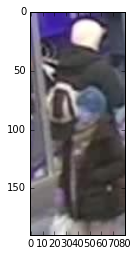

[ 97.36155512]


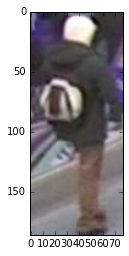

[ 103.38139459]


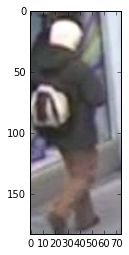

[ 118.17397726]


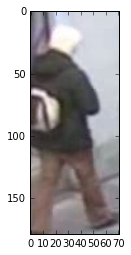

[ 133.68945891]


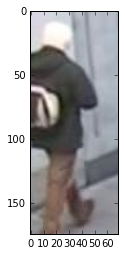

[ 132.315804]


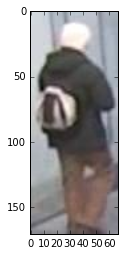

[ 129.56376015]


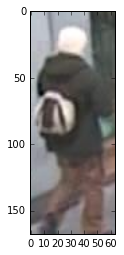

[ 113.26209077]


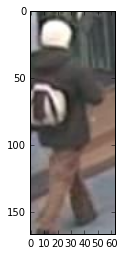

[ 103.58913918]


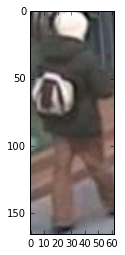

[ 100.34269335]


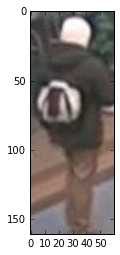

[ 99.74786059]


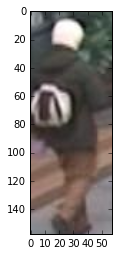

[ 97.21842718]


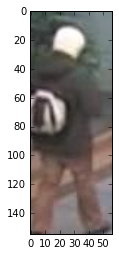

[ 102.80626297]


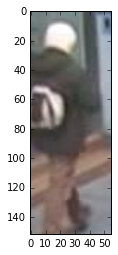

[ 114.58787879]


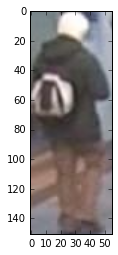

[ 114.28886213]


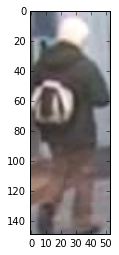

[ 117.19074754]


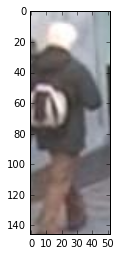

[ 126.68378995]


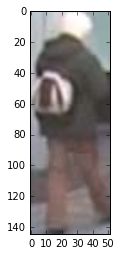

[ 118.20742706]


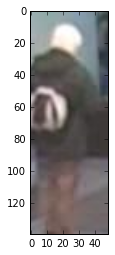

[ 108.30019436]


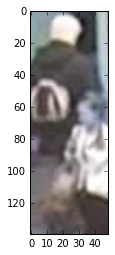

[ 125.15806608]


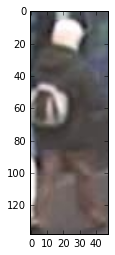

[ 99.64185789]


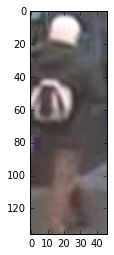

[ 97.42657489]


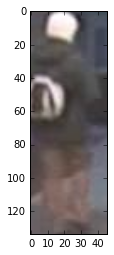

[ 97.02784988]


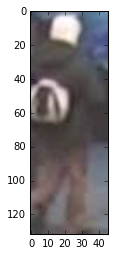

[ 100.24901186]


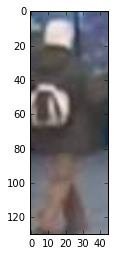

[ 102.8219943]


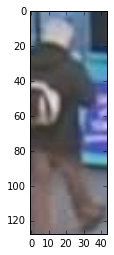

[ 107.10919744]


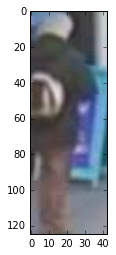

[ 108.02703876]


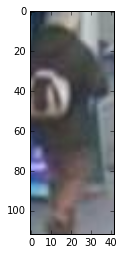

[ 103.70719955]


In [9]:
# Now, let's see some examples of how this works
data = np.loadtxt(GT_PATH,delimiter=',')
data = data[:, [0, 1, 2, 3, 4, 5]] # t, id, x, y, w, h
data = np.int32(data)

traj = data[data[:, 1] == 3]
# all bounding boxes belonging to a person with id 3
for idx in range(len(traj)):
    bbox_image = read_bounding_box(traj[idx, 2], traj[idx, 3], traj[idx, 4], traj[idx, 5], traj[idx, 0])
    plt.imshow(bbox_image)
    plt.show()
    print bounding_box_to_feature_vector(bbox_image)

In [10]:
# Ok, now let's do some evaluation of the quality of our system
# Let's start with the following simple metric:
# For each trajectory, for each pair of neighbouring frames, 
# we compute the distance between the bounding boxes
# (This should obviously be as small as possible)
# For each bounding box, compute the minimum distance to all bounding boxes 
# in the next frame NOT belonging to the same peron
# (This should obviously be as big as possible)
# Take our metric to be sum of the first values MINUS the sum of the second values
# And, of course, normalize this metric over the number of terms in both sums
# (We want to minimize this this metric, of course)

# We will return the overall score, and an Nx5 matrix, where each row contains
# the following: 
# index of bounding box, 
# index of this person's bounding box in the next frame, 
# distance between them,
# index of the person which looks most similar in the next frame, but is not our person
# distance between them
def simple_evaluation(data, features, distance_between_representations_function):
    pairs_compared = 0
    total_score = 0
    
    eval_result = np.zeros((0, 5))
    
    
    features = np.asarray(features)
    
    for idx in range(len(data)):
        # All bounding boxes in the next frame
        data_next_idx = np.where(data[:, 0] == data[idx, 0] + 1)[0]
        
        positive_distance = +100
        negative_distance = +100
        negative_index = -1
        positive_index = -1
        for jdx in data_next_idx:
            # If it is the same person, save as positive distance, else save as negative distance
            if data[jdx, 1] == data[idx, 1]:
                positive_distance = distance_between_representations_function(features[idx, :], features[jdx, :])
                positive_index = jdx
            else:
                negative_candidate = distance_between_representations_function(features[idx, :], features[jdx, :])
                if negative_candidate < negative_distance:
                    negative_distance = negative_candidate
                    negative_index = jdx
                                        
        
        # We either didn't have the same person in the next frame, 
        # or we didn't have anothe people in the next frame
        # Skipping in such case
        if (negative_index == -1 or positive_index == -1):
            continue
        
        total_score += positive_distance - negative_distance
        pairs_compared += 1
        
        eval_result = np.vstack((eval_result, 
                                 np.array([idx, 
                                           positive_index, 
                                           positive_distance, 
                                           negative_index, 
                                           negative_distance])))
        
        
    return total_score / pairs_compared, eval_result

In [12]:
# Let's take first 10 trajectories
subset = data[data[:, 1] <= 10]
# Compute their features
features = np.asarray([bounding_box_to_feature_vector(read_bounding_box(x = subset[idx, 2], 
                                                                        y = subset[idx, 3], 
                                                                        w = subset[idx, 4], 
                                                                        h = subset[idx, 5], 
                                                                        t = subset[idx, 0]))
                       for idx in range(len(subset))])

# And evaluate what we got
score, eval_result = simple_evaluation(data = subset,
                                       features = features,
                                       distance_between_representations_function = distance_between_representations)
print score


[  7.16204751e-05]


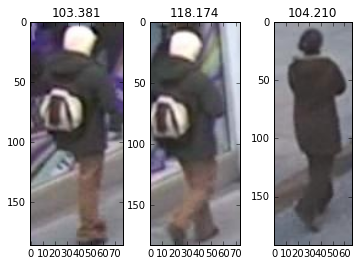

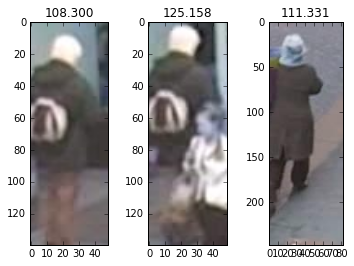

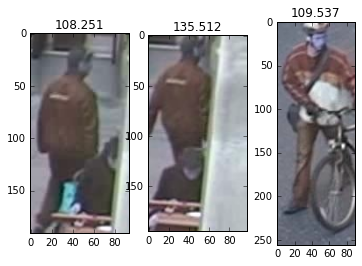

In [13]:
# Doesn't seem too good, right? Number is very close to 0, 
# meaning that in most cases there is a person in the next frame
# that looks almost the same way as our person of interest looks
# Finally, let's try to look at the couple of examples where
# We see that some other person is closer than our person:
sub_result = eval_result[eval_result[:, 2] - eval_result[:, 4] > 0.05]

for idx in range(len(sub_result)):
    our_idx = np.int32(sub_result[idx, 0])
    nxt_idx = np.int32(sub_result[idx, 1])
    bad_idx = np.int32(sub_result[idx, 3])
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(read_bounding_box(x = subset[our_idx, 2], 
                                 y = subset[our_idx, 3],
                                 w = subset[our_idx, 4], 
                                 h = subset[our_idx, 5], 
                                 t = subset[our_idx, 0]))
    ax2.imshow(read_bounding_box(x = subset[nxt_idx, 2], 
                                 y = subset[nxt_idx, 3],
                                 w = subset[nxt_idx, 4], 
                                 h = subset[nxt_idx, 5], 
                                 t = subset[nxt_idx, 0]))
    ax3.imshow(read_bounding_box(x = subset[bad_idx, 2], 
                                 y = subset[bad_idx, 3],
                                 w = subset[bad_idx, 4], 
                                 h = subset[bad_idx, 5], 
                                 t = subset[bad_idx, 0]))
    ax1.set_title('%0.3f' % features[our_idx, 0])
    ax2.set_title('%0.3f' % features[nxt_idx, 0])
    ax3.set_title('%0.3f' % features[bad_idx, 0])
    plt.show()
    